In [ ]:
pip install pmdarima

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [ ]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv       dataframe_flow_variable_60min.csv
dataframe_dma_flow_60min.csv    DMA_225.csv
dataframe_flow_1D.csv           DMA_468.csv
dataframe_flow_variable_1D.csv  persistence_results.pkl


In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_468.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')
data.rename( columns={'Flow':'DMA_468','Date-time':'Date_time'}, inplace=True )
data_DMA468 = data[['Date_time','DMA_468']]

In [ ]:
figure = px.line(data_DMA468,x="Date_time",y="DMA_468",title="DMA_468 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="12m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="8m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="4m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [ ]:
data_DMA468.dropna(subset = ["DMA_468"], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_DMA468_indexed = data_DMA468.set_index('Date_time')
# Making hourly data 
hourly_data = data_DMA468_indexed.resample('h').sum()
hourly_data.shape
hourly_data_index = hourly_data.reset_index()

In [ ]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest()
model.fit(hourly_data_index[['DMA_468']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [ ]:
score=model.decision_function(hourly_data_index[['DMA_468']])

In [ ]:
hourly_data_index['scores'] = score
hourly_data_index_final = hourly_data_index[hourly_data_index.scores >-0.25]
final_df = hourly_data_index_final[['Date_time','DMA_468']]

In [ ]:
hourly_data_index_final.shape

(8733, 3)

In [ ]:
final_df.shape

(8733, 2)

In [ ]:
figure = px.line(final_df,x="Date_time",y="DMA_468",title="DMA_468 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="12m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="8m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="4m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [ ]:
#Statistical information
final_df.describe()

,DMA_468
count,8733.000000
mean,3.286168
std,1.766058
min,0.000000
25%,1.467000
50%,3.578000
75%,4.689000
max,7.688000


In [ ]:
final_df1 = final_df.set_index('Date_time')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

In [ ]:
# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(final_df1)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.740201
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Observation :

1.The ADF statistic value of -10.7. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value - 0.000 < 0.05 ; Data is stationary

In [ ]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(final_df1)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.17669641254703597,
 0.1,
 37,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation : 1.The ADF statistic value of 0.17. The positive value is statistic, and hence we have a stationary dataset

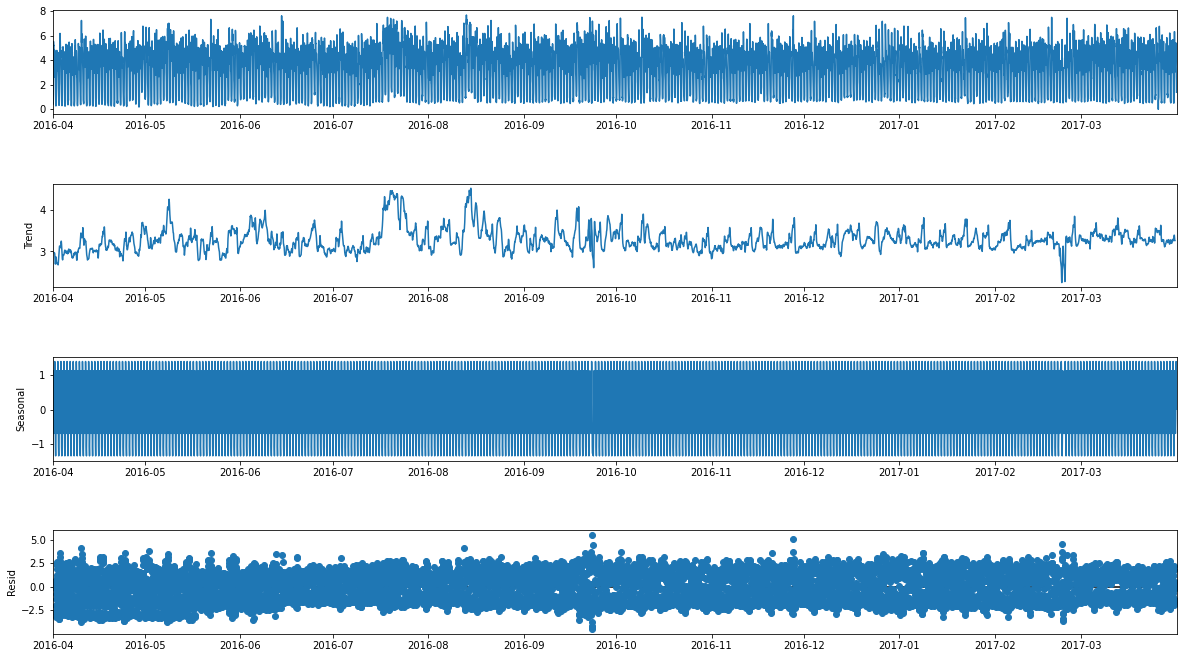

In [ ]:
import statsmodels.api as sm
res=sm.tsa.seasonal_decompose(final_df1,period=24)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

# Baseline model

In [ ]:
# Making a df
Original = final_df1["DMA_468"].to_frame().rename(columns = {"DMA_468": "Original" })
Forecast  = final_df1["DMA_468"].to_frame().shift(1).rename(columns = {"DMA_468": "Forecast" })
baseline = pd.concat([Original,Forecast],axis=1)
final = baseline[1:]#there is no prediction for first row due to shifting.
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(final.Original, final.Forecast))
rmse = round(rmse, 3)
print (" The root mean square value on dataset: ",rmse)

 The root mean square value on dataset:  0.871


<Figure size 1584x720 with 0 Axes>

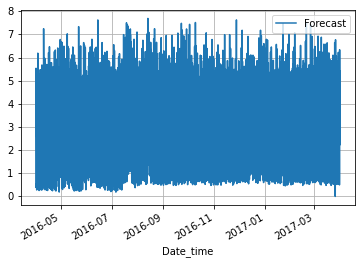

<Figure size 1584x720 with 0 Axes>

In [ ]:
baseline_model = final[['Forecast']]
baseline_model.plot(grid=True)
plt.figure(figsize=(22,10))

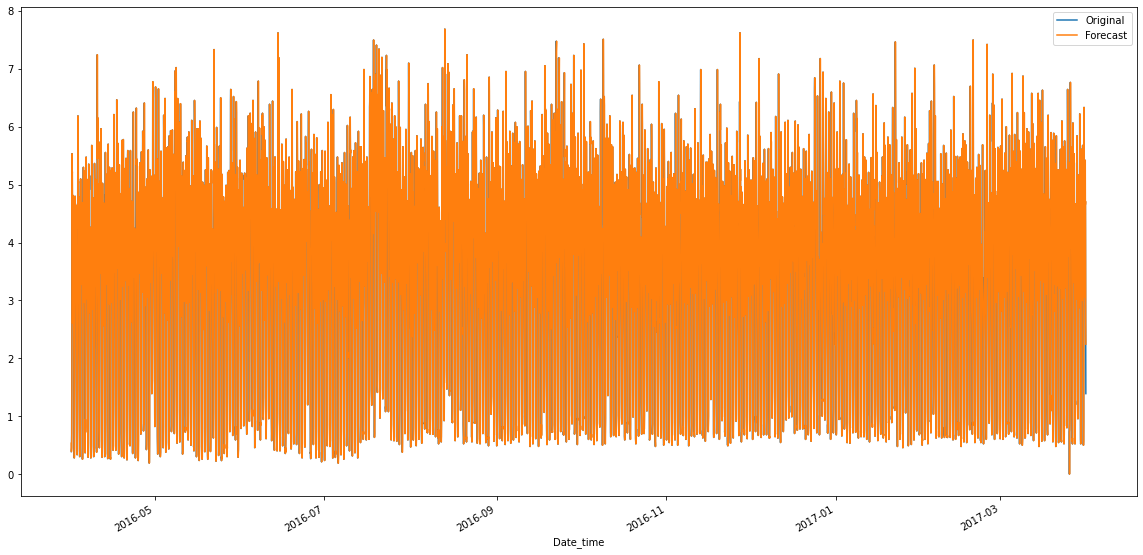

In [ ]:
final.plot(figsize=(20,10))

In [ ]:
final.iloc[-2620:]

,Original,Forecast
Date_time,,
2016-12-12 08:00:00,5.911,4.255
2016-12-12 09:00:00,4.756,5.911
2016-12-12 10:00:00,4.377,4.756
2016-12-12 11:00:00,3.001,4.377
2016-12-12 12:00:00,3.355,3.001
...,...,...
2017-03-31 19:00:00,4.711,4.655
2017-03-31 20:00:00,3.211,4.711
2017-03-31 21:00:00,2.667,3.211


 The root mean square value on dataset using baseline model:  0.842


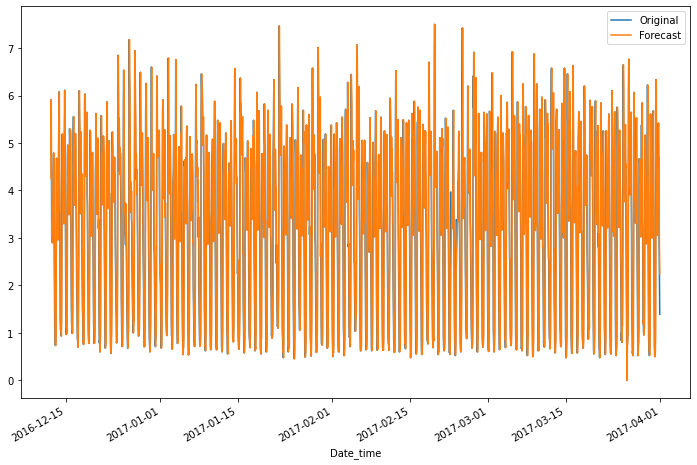

In [ ]:
baseline_graph = final[-2620:]
rmse1 = np.sqrt(mean_squared_error(baseline_graph.Original, baseline_graph.Forecast))
rmse1 = round(rmse1, 3)
print (" The root mean square value on dataset using baseline model: ",rmse1)
baseline_graph.plot(figsize=(12,8))

# LSTM

In [ ]:
# Split train data and test data
train_size = int(len(final_df1)*0.7)

#train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = final_df1.iloc[:train_size]
test_data = final_df1.iloc[train_size:]

In [ ]:
train_data.shape

(6113, 1)

In [ ]:
test_data.shape

(2620, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

In [ ]:
def data_preparation(array_dataset, look_back=1, future=1, index=0):
    features = array_dataset.shape[1]
    arr_X, arr_Y = [], []
    if len(array_dataset) - look_back <= 0:
        arr_X.append(array_dataset)
    else:
        for i in range(len(array_dataset) - look_back - future):
            arr_Y.append(array_dataset[(i + look_back):(i + look_back + future), index])
            arr_X.append(array_dataset[i:(i + look_back)])
    arr_X, arr_Y = np.array(arr_X), np.array(arr_Y)
    arr_X = np.reshape(arr_X, (arr_X.shape[0], look_back, features))
    return arr_X, arr_Y

look_back = 12
features = 1
X_train, Y_train = data_preparation(train_scaled, look_back=12, future=24, index=0)
X_test, Y_test = data_preparation(test_scaled, look_back=12, future=24, index=0)

In [ ]:
X_train = X_train1.reshape((X_train1.shape[0],X_train1.shape[1],1))
X_test = X_test1.reshape( (X_test1.shape[0],X_test1.shape[1],1))

In [ ]:
print('X_train shape:',X_train.shape)
print('Y_train shape:',Y_train.shape)
print('X_test shape:',X_test.shape)
print('Y_test shape:',Y_test.shape)

X_train shape: (6077, 12, 1)
Y_train shape: (6077, 24)
X_test shape: (2584, 12, 1)
Y_test shape: (2584, 24)


In [ ]:
model8 = tf.keras.Sequential()
model8.add(LSTM(150,return_sequences=True,input_shape=(look_back,features)))
model8.add(Dropout(0.45))
model8.add(LSTM(120,return_sequences=True))
model8.add(Dropout(0.35))
model8.add(LSTM(100))
model8.add(Dropout(0.25))
model8.add(Dense(24))
model8.compile(loss='mean_squared_error', optimizer='adam')
history8=model8.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=200,batch_size=100)

Epoch 1/200
61/61 [==============================] - 15s 152ms/step - loss: 0.0805 - val_loss: 0.0470
Epoch 2/200
61/61 [==============================] - 8s 133ms/step - loss: 0.0427 - val_loss: 0.0301
Epoch 3/200
61/61 [==============================] - 8s 132ms/step - loss: 0.0349 - val_loss: 0.0262
Epoch 4/200
61/61 [==============================] - 8s 133ms/step - loss: 0.0297 - val_loss: 0.0214
Epoch 5/200
61/61 [==============================] - 8s 132ms/step - loss: 0.0258 - val_loss: 0.0185
Epoch 6/200
61/61 [==============================] - 8s 132ms/step - loss: 0.0227 - val_loss: 0.0143
Epoch 7/200
61/61 [==============================] - 8s 132ms/step - loss: 0.0195 - val_loss: 0.0139
Epoch 8/200
61/61 [==============================] - 8s 133ms/step - loss: 0.0175 - val_loss: 0.0119
Epoch 9/200
61/61 [==============================] - 8s 132ms/step - loss: 0.0168 - val_loss: 0.0119
Epoch 10/200
61/61 [==============================] - 8s 133ms/step - loss: 0.0159 - val_l

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history8.history['loss'])
    plt.plot(history8.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

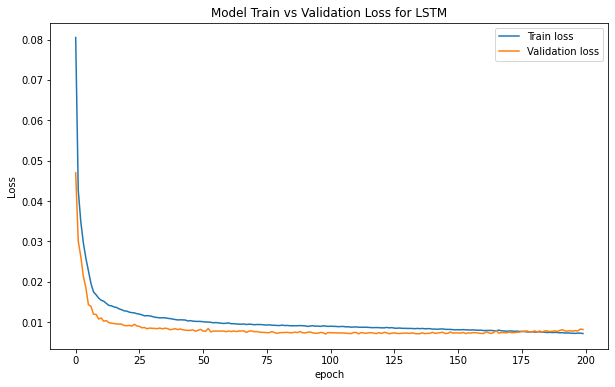

In [ ]:
plot_loss(history8,'LSTM')

In [ ]:
# Generate predictions
train_pred = model8.predict(X_train)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model8.predict(X_test)
predictions = test_pred

In [ ]:
final_df2= final_df1.reset_index()

In [ ]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0]))
#final_df = pd.DataFrame((y_test[0]))
final_data = pd.DataFrame((Y_test))
final_data.rename(columns = {0:'original_value'}, inplace = True)
final_data['predicted_value'] = lstm_df

In [ ]:
import math
from sklearn.metrics import mean_squared_error
testset = math.sqrt(mean_squared_error(final_data['original_value'], final_data['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  0.06179173639570277


In [ ]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model8.predict(X_test)]
y = [y[0] for y in Y_test]
# Creating the frame to store both predictions
days = final_df2[['Date_time']].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_data], axis=1, join='inner')
result.shape

(2584, 26)

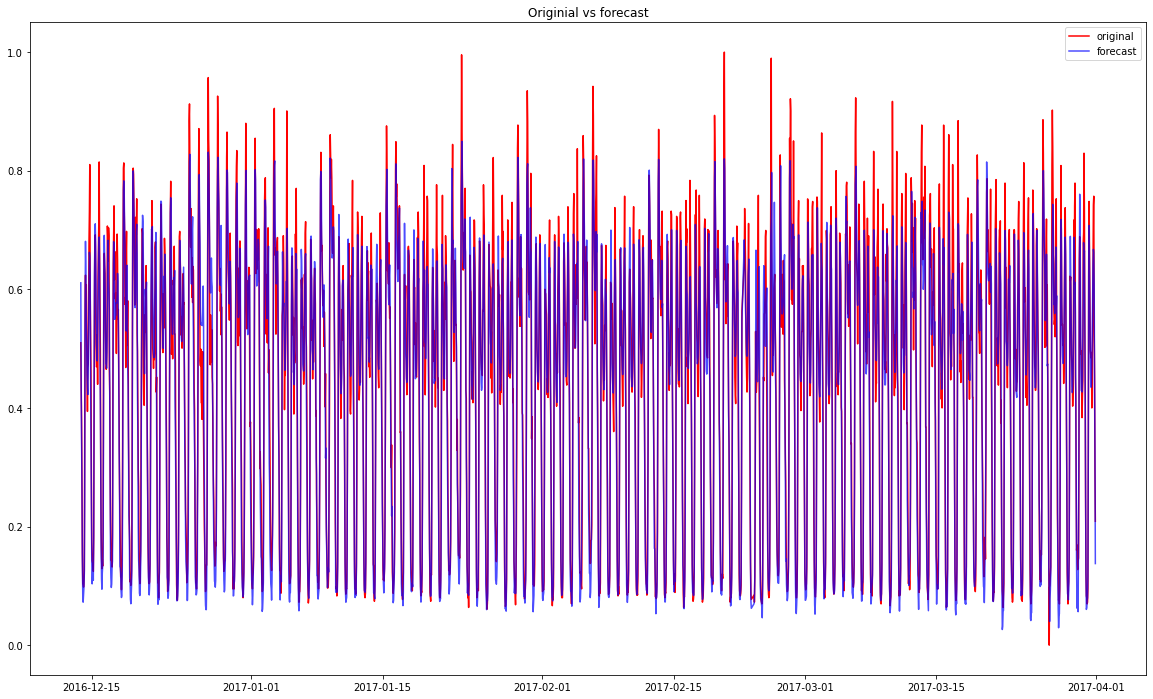

In [ ]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [ ]:
df.to_csv('raw_data.csv', index=False)
df.to_excel('raw_data.xls', index=False)

In [ ]:
from google.colab import files

# e.g. save pandas output as csv
result.to_csv('DMA_468_ULSTM_hp.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('DMA_468_ULSTM_hp.csv')